# Leakage Randomized Benchmarking Example

In [1]:
import warnings
warnings.filterwarnings("ignore") # bad practice, but pystan has a bunch of annoying warnings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

import pystan as ps
import numpy as np
from scipy.optimize import curve_fit, bisect
import scipy.stats as st
import utils as su
import seaborn as sbn
import pandas as pd

su.overwrite = True

## Data Generation

Function to load in the simulated survival probabilities from Mathematica's output (`survival-distributions.nb`), and use it to simulate some bernoulli trials.

In [2]:
rbd = su.RBSimData('../data/lrb-dephasing_z_andL1L2.h5')
survivals = rbd.survival_data[:,0,:,0,:,:]
Nmeas = survivals.shape[-2]
Nstates = survivals.shape[-1]

mlist = rbd.sequence_lengths
Nm = mlist.shape[0]
Nsamp = 15
Nbin = 30

def datavals(Nmeas, Nstates, Nsamp, Nbin):
    datavals = np.empty((Nm, Nsamp, Nmeas, Nstates), dtype='int')
    for idx_m in range(Nmeas):
        for idx_s in range(Nstates):
            for k, m in enumerate(mlist):
                datavals[k,:,idx_m,idx_s] = np.random.binomial(Nbin, survivals[k,:Nsamp,idx_m,idx_s])
    return datavals
    
def data_one_meas():
    return dict(
        Nm=Nm, Nsamp=20, Nbin=30, Nc=10, d=2,
        m=mlist,
        Nmeas=1,
        Nstates=2,
        Q=datavals(1,2,20,30),
        F_est=0.99,
        L1_est=0.001,
        L2_est=0.001,
        A_est=0.5 * np.ones(1), A_est_t=0.5,
        B_est=0.01 * np.ones(1), B_est_t=0.5,
        C_est=np.array([[0.99,0.01]]), C_est_t=0.5,
        F_prior_cutoff=0,
        F_prior_z=0,
        Lobs=np.array([1,1,100]),
        Aobs=np.array([[100],[100]]),
        Bobs=np.array([[1],[100]]),
        Cobs=np.array([[[10,1]],[[1,10]]])
    )

data_one_state = dict(
    Nm=Nm, Nsamp=30, Nbin=30, Nc=10, d=2,
    m=mlist,
    Nmeas=2,
    Nstates=1,
    Q=datavals(2,1,30,30),
    F_est=0.98, F_std=0.05,
    pl_est=0.01, pl_std=0.05,
    L1_est=0.01, L1_std=0.05,
    L2_est=0.01, L2_std=0.05,
    A_est=0.5 * np.ones(2), A_est_t=0.5,
    B_est=0.01 * np.ones(2), B_est_t=0.5,
    C_est=np.array([[0.99],[0.01]]), C_est_t=0.5
)

data_all = dict(
    Nm=Nm, Nsamp=10, Nbin=30, Nc=10, d=2,
    m=mlist,
    Nmeas=2,
    Nstates=2,
    Q=datavals(2,2,10,30),
    F_est=0.99, F_std=0.05,
    pl_est=0.001, pl_std=0.005,
    L1_est=0.001, L1_std=0.005,
    L2_est=0.001, L2_std=0.005,
    A_est=0.5 * np.ones(2), A_est_t=0.5,
    B_est=0.01 * np.ones(2), B_est_t=0.5,
    C_est=np.array([[0.99,0.01],[0.01,0.99]]), C_est_t=0.5
)

## Dirichlet Process Stan Model

Load in two stan models, both use CDPBM, but the latter allows non-uniform prior.

In [3]:
model = su.StanModelFactory('./stan/lrb-dp.stan').model
model_with_prior = su.StanModelFactory('./stan/lrb-dp-prior.stan').model

In [ ]:
fit = model.sampling(data=data_one_meas(), iter=1000, chains=4, control=dict(adapt_delta=0.9))

In [ ]:
fit_with_prior = model_with_prior.sampling(data=data_one_meas(), iter=1000, chains=4, control=dict(adapt_delta=0.9))

Overwriting ../fig/lrb-posterior.png
Overwriting ../fig/lrb-posterior.pdf


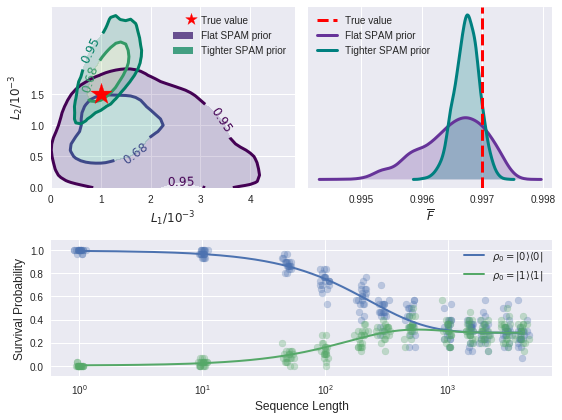

In [51]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4,4],height_ratios=[4,3]) 

#----------------------------------------------------
# F posterior
#----------------------------------------------------
labels = ['Flat SPAM prior', 'Tighter SPAM prior']
ax = plt.subplot(gs[0,1])
sbn.kdeplot(fit.extract()['F'][:], shade=True, lw=3, c='rebeccapurple', label=labels[0])
sbn.kdeplot(fit_with_prior.extract()['F'][:], shade=True, lw=3, c='teal', label=labels[1])
plt.axvline(0.997, c='r', lw=3, linestyle='--', label='True value')
plt.xlabel(r'$\overline{F}$', fontsize=12)
plt.xticks([0.995,0.996,0.997,0.998])
plt.yticks([])
plt.legend()
h,l = plt.gca().get_legend_handles_labels()
order=[2,0,1]
plt.legend([h[i] for i in order], [l[i] for i in order])

#----------------------------------------------------
# L1-L2 posterior
#----------------------------------------------------

cmaps = ['viridis', 'summer']
legend_markers = []
for idx_fit, thisfit in enumerate([fit, fit_with_prior]):
    ax = plt.subplot(gs[0,0])
    mult = 1e3
    x = thisfit.extract()['L1'][:]
    y = thisfit.extract()['L2'][:]

    H,xedges,yedges=np.histogram2d(x,y,bins=40,normed=True)
    kde = st.gaussian_kde(np.vstack([x,y]))
    xx, yy = np.mgrid[0:0.005:.0001, 0:0.003:.0001]
    density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)

    def objective(limit, target):
        w = np.where(H>limit)
        count = H[w]
        return count.sum() - target
    credible_levels = [0.95,0.68,0]
    levels = [
        bisect(objective, H.min(), H.max(), args=(contour * H.sum(),))
        for contour in credible_levels
    ]

    cset1 = plt.contourf(mult * xx, mult * yy, density, label=labels[idx_fit], cmap=cmaps[idx_fit], levels=levels, alpha=0.2)
    cset = plt.contour(mult * xx, mult * yy, 
                density, cmap=cset1.get_cmap(), levels=levels, linewidths=3)
    level_text = {level:'${}$'.format(clevel) for level, clevel in zip(cset.levels, credible_levels)}
    plt.clabel(cset, cset.levels[:], inline=True, fmt=level_text, fontsize=12)
    legend_markers += [plt.Rectangle((0,0),1,1,alpha=0.8,facecolor = cset1.collections[0].get_facecolor()[0])]

plt.scatter([mult * 0.001],[mult * 0.0015],c='r',marker='*',s=500,zorder=50,label='True value')

plt.xlabel(r'$L_1/ 10^{-3}$', fontsize=12)
plt.ylabel(r'$L_2/ 10^{-3}$', fontsize=12)
plt.yticks([0,0.5,1,1.5])
lgnd = plt.legend()
h, l = plt.gca().get_legend_handles_labels()
h += legend_markers
l += labels
lgnd = plt.legend(h, l)
lgnd.legendHandles[0]._sizes = [150]
lgnd.legendHandles[0]._offsets += np.array([[8,2]])

#----------------------------------------------------
# Data and Fits
#----------------------------------------------------

ax = plt.subplot(gs[1,:])
blue = sbn.color_palette()[0]
green = sbn.color_palette()[1]

Nm = fit.data['Nm']
Nsamp = fit.data['Nsamp']
Nbin = float(fit.data['Nbin'])

for idx in range(Nm):
    plt.scatter(
        mlist[idx] + 0.05 * mlist[idx]* np.random.randn(Nsamp),
        fit.data['Q'][idx,:,0,0] / Nbin,
        c=blue,
        alpha=0.3
    )
    plt.scatter(
        mlist[idx] + 0.05 * mlist[idx]* np.random.randn(Nsamp),
        fit.data['Q'][idx,:,0,1] / Nbin,
        c=green,
        alpha=0.3
    )
    
ms = np.arange(1, mlist.max())
def lrb_curve(L1, L2, mu1, A, B, C):
    return (L2 * A + L1 * B) / (L1 + L2) \
        + (L1 / (L1 + L2)) * (A - B) * (1 - L1 - L2) ** ms \
        + (C - A) * ((1 - L1) * mu1) ** ms
        
for idx in np.random.randint(500, size=2):
    mean0 = [fit.extract()[field][idx,...] for field in ['L1', 'L2', 'mu1', 'A', 'B', 'C']]
    mean0[-1] = mean0[-1][0,0]
    mean1 = [fit.extract()[field][idx,...] for field in ['L1', 'L2', 'mu1', 'A', 'B', 'C']]
    mean1[-1] = mean1[-1][0,1]
    plt.plot(ms, lrb_curve(*mean0), lw=0.5, c=blue, alpha=0.05)
    plt.plot(ms, lrb_curve(*mean1), lw=0.5, c=green, alpha=0.05)

mean0 = [np.mean(fit.extract()[field][:,...], axis=0) for field in ['L1', 'L2', 'mu1', 'A', 'B', 'C']]
mean0[-1] = mean0[-1][0,0]
mean1 = [np.mean(fit.extract()[field][:,...], axis=0) for field in ['L1', 'L2', 'mu1', 'A', 'B', 'C']]
mean1[-1] = mean1[-1][0,1]

plt.plot(ms, lrb_curve(*mean0), c= blue, lw=2, label=r'$\rho_0=|0\rangle\langle 0 |$')
plt.plot(ms, lrb_curve(*mean1), c=green, lw=2, label=r'$\rho_0=|1\rangle\langle 1 |$')
    
plt.xscale('log', basex=10)
plt.xlabel('Sequence Length', fontsize=12)
plt.legend()
plt.ylabel('Survival Probability', fontsize=12)

plt.tight_layout()

su.overwrite=True
su.export_figure(fig=fig, name='lrb-posterior')

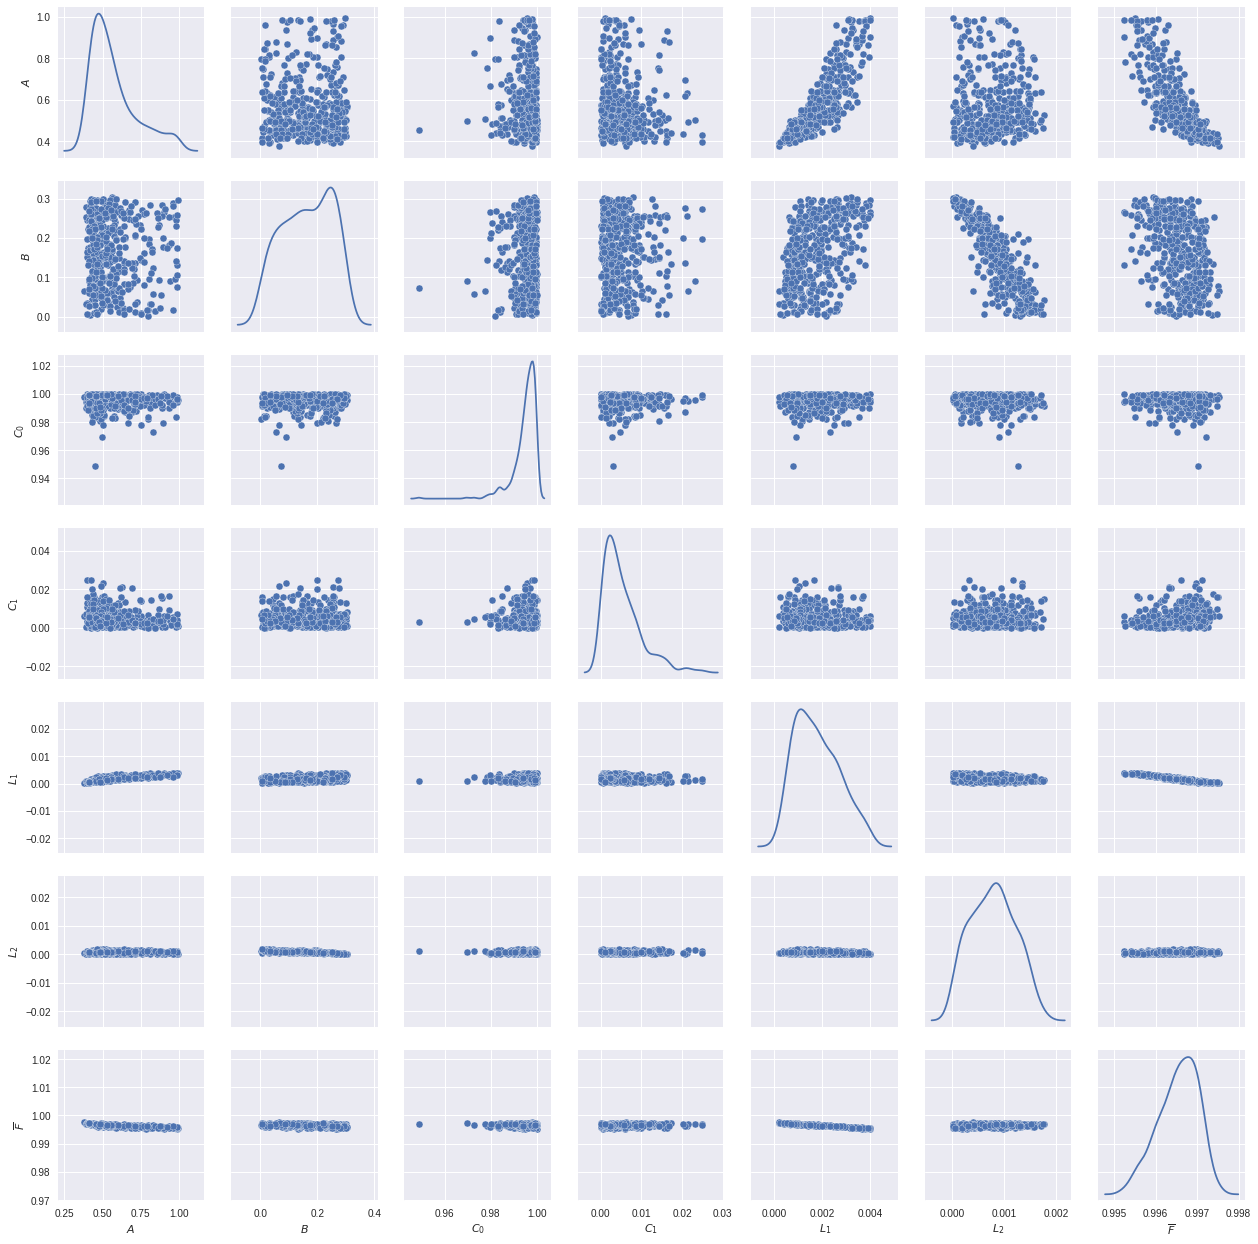

In [8]:
def get_field(field):
    try:
        name, f, idxs = field
        return fit.extract()[f][idxs]
    except:
        name, f = field
        return fit.extract()[f][::10]
    
dataframe = pd.DataFrame(
    data={
       field[0]:get_field(field) for field in 
        [
            ('$L_1$', 'L1'), 
            ('$L_2$', 'L2'), 
            (r'$\overline{F}$', 'F'), 
            ('$A$', 'A'),
            ('$B$','B'), 
            ('$C_0$', 'C',np.s_[::10,0,0]),
            ('$C_1$', 'C',np.s_[::10,0,1])
        ]
    }
)

sbn.pairplot(data=dataframe, diag_kind='kde')